# Multivariate Time Series Models

In [61]:
%matplotlib inline

import os
import sys
import warnings
from datetime import date
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

In [11]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', context='notebook', color_codes=True)

In [12]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [24]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

## Load Data

In [5]:
sent = 'UMCSENT'
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2017-12').dropna()
df.columns = ['sentiment', 'ip']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 1972-02-01 to 2017-12-01
Data columns (total 2 columns):
sentiment    504 non-null float64
ip           504 non-null float64
dtypes: float64(2)
memory usage: 11.8 KB


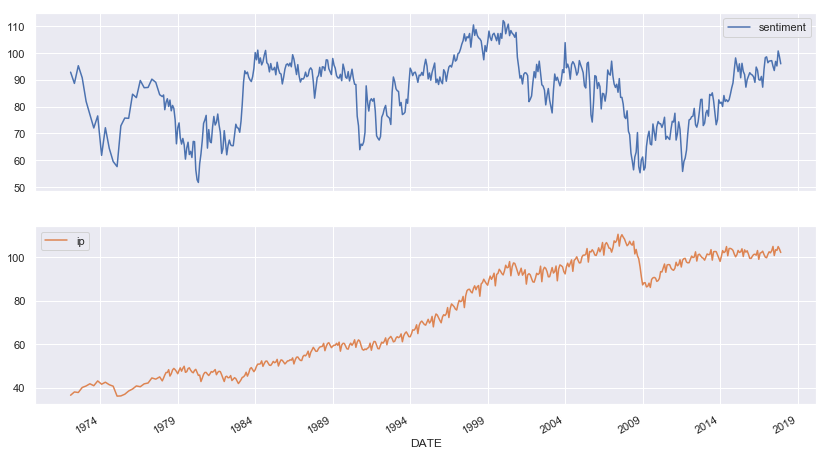

In [7]:
df.plot(subplots=True, figsize=(14,8));

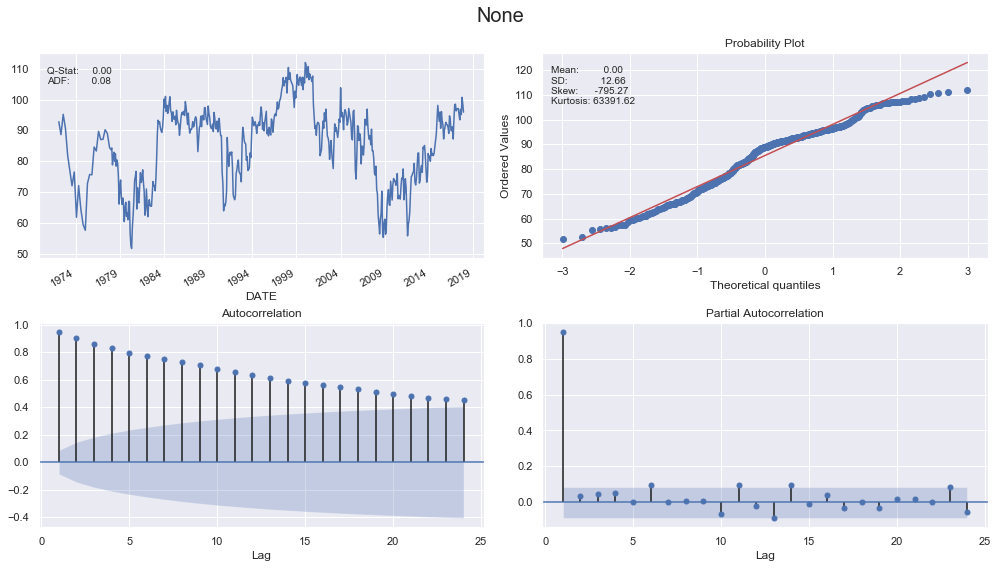

In [16]:
plot_correlogram(df.sentiment, lags=24)

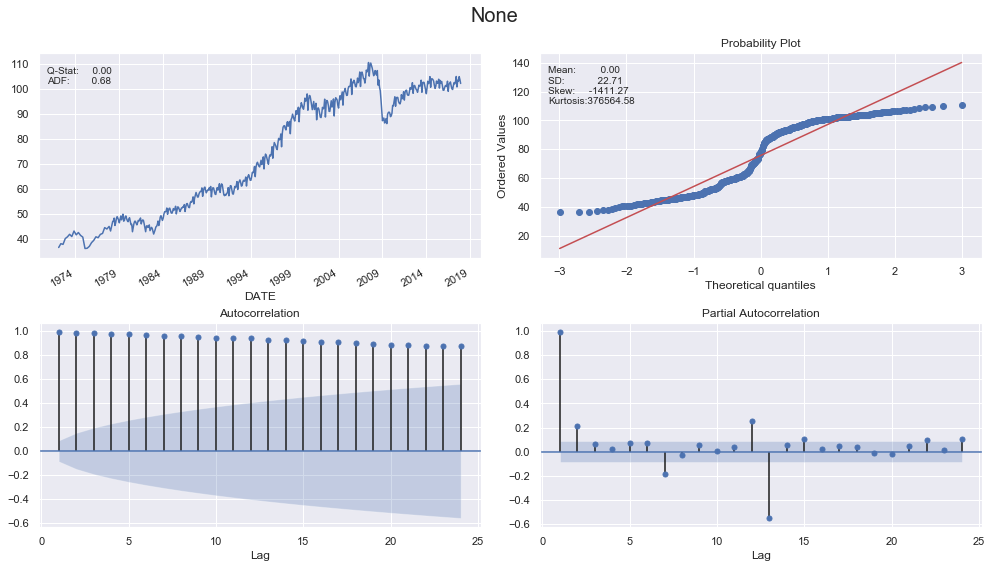

In [17]:
plot_correlogram(df.ip, lags=24)

## Stationarity Transform

In [18]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna()

## Inspect Correlograms

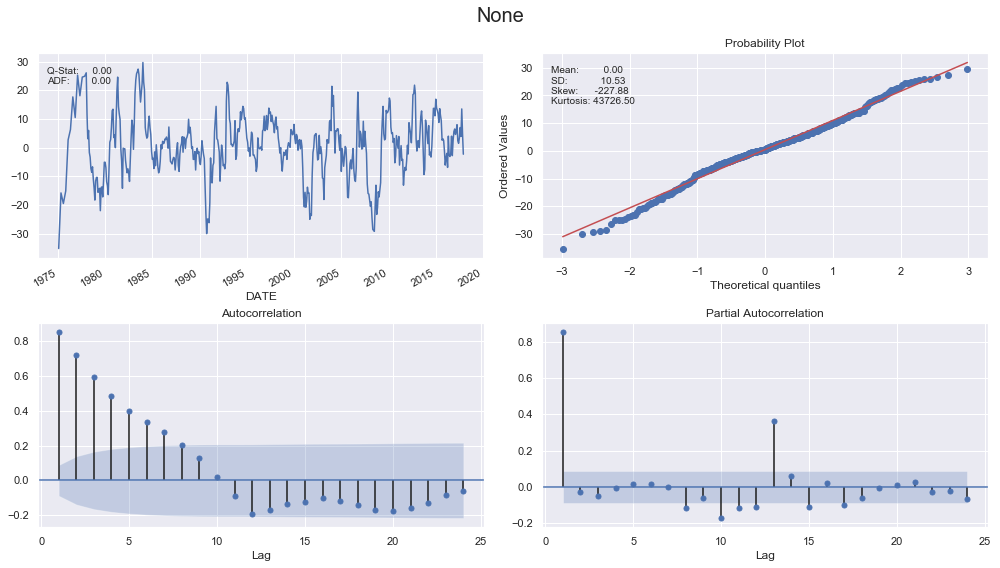

In [20]:
plot_correlogram(df_transformed.sentiment, lags=24)

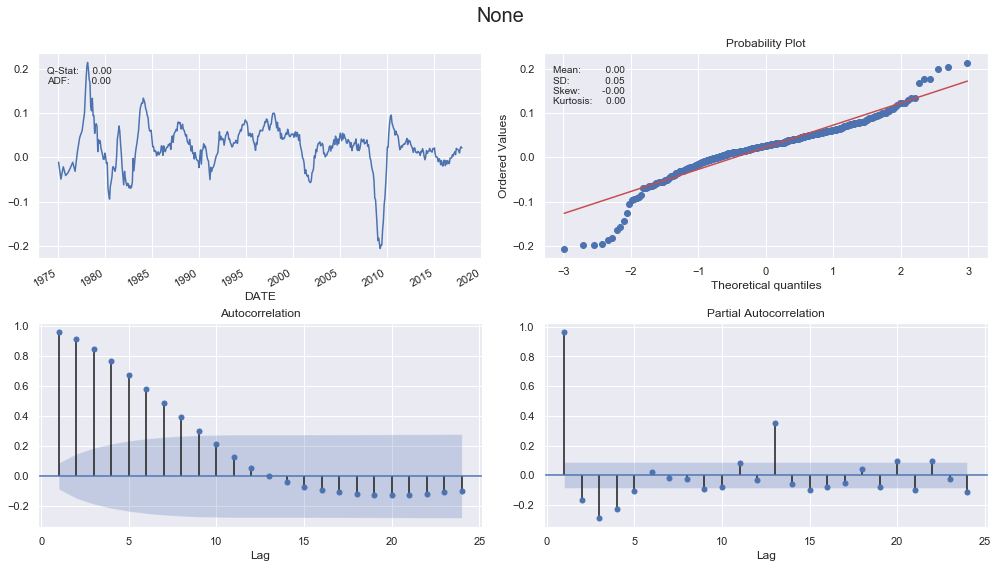

In [22]:
plot_correlogram(df_transformed.ip, lags=24)

In [36]:
test_unit_root(df_transformed)

          p-value
ip          0.03%
sentiment   0.00%


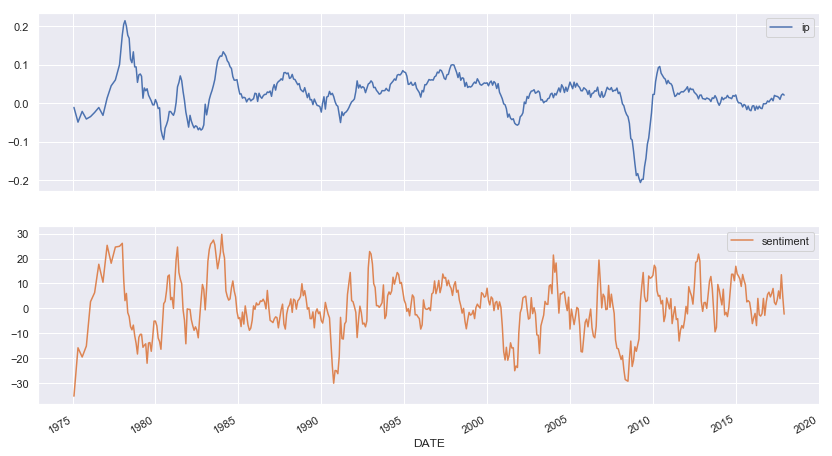

In [26]:
df_transformed.plot(subplots=True, figsize=(14,8));

## VAR Model

In [37]:
model = VARMAX(df_transformed.iloc[:480], order=(1,1), trend='c').fit(maxiter=1000)
print(model.summary())

                            Statespace Model Results                           
Dep. Variable:     ['ip', 'sentiment']   No. Observations:                  480
Model:                      VARMA(1,1)   Log Likelihood                 -68.938
                           + intercept   AIC                            163.875
Date:                 Sun, 23 Sep 2018   BIC                            218.134
Time:                         17:52:53   HQIC                           185.203
Sample:                              0                                         
                                 - 480                                         
Covariance Type:                   opg                                         
Ljung-Box (Q):              129.82, 165.15   Jarque-Bera (JB):        140.59, 16.05
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.47, 1.10   Skew:                       0.19, 0.21
Prob(H) (two-sided):        

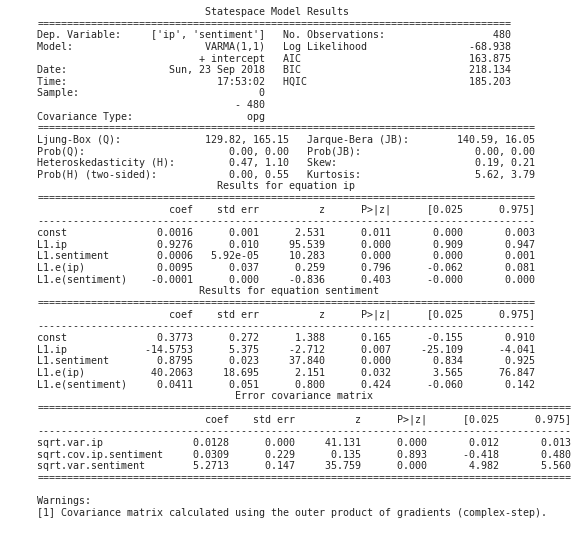

In [38]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('var_summary.png', bbox_inches='tight', dpi=300);

### Plot Diagnostics

#### Industrial Production

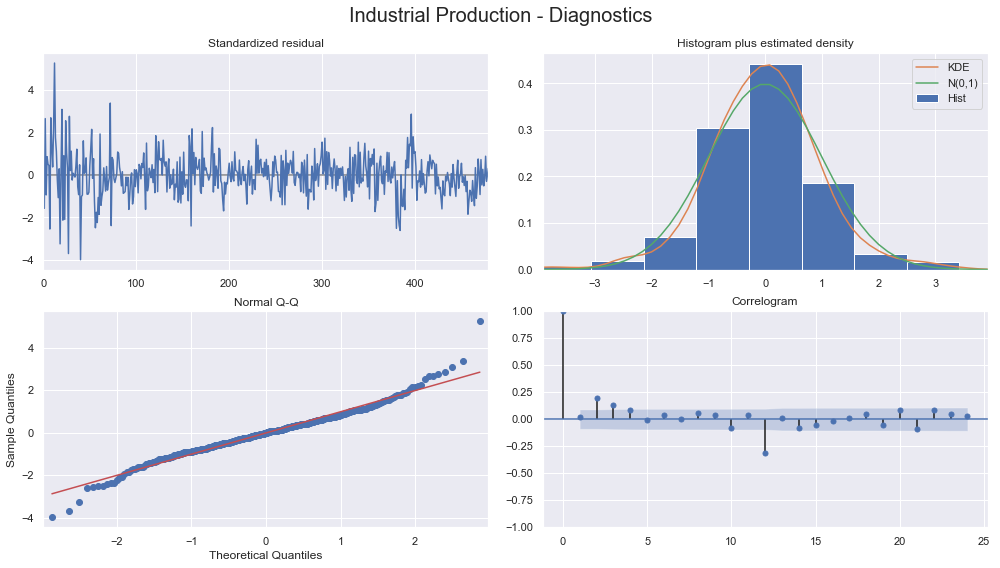

In [56]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

#### Sentiment

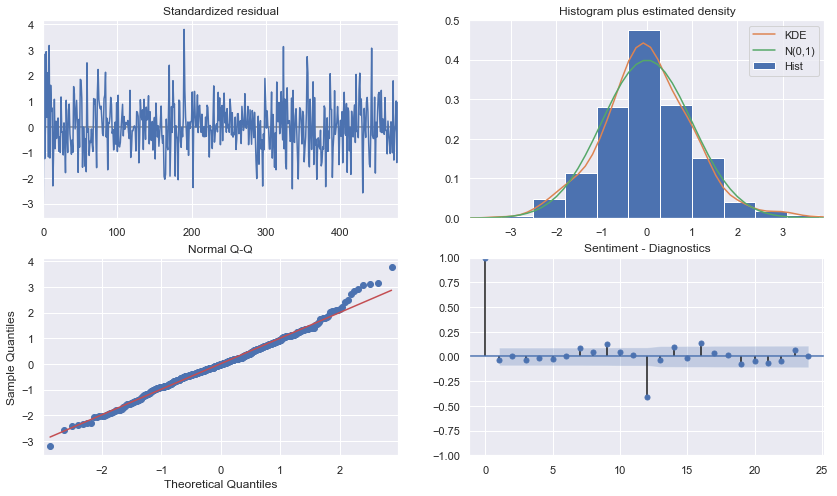

In [35]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Sentiment - Diagnostics');

### Impulse-Response Function

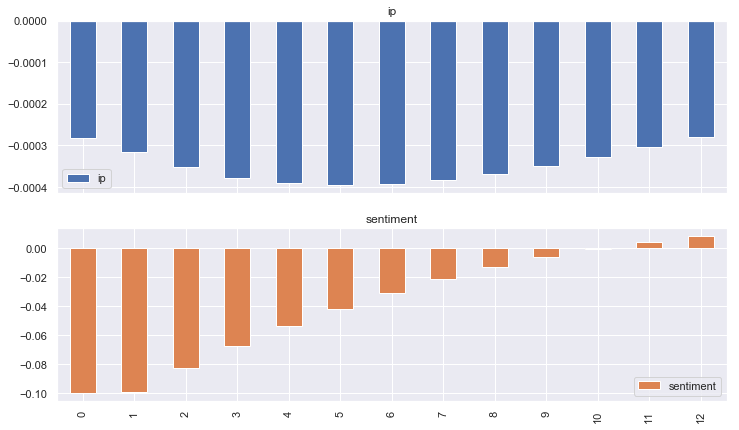

In [49]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12, impulse=median_change).plot.bar(subplots=True);

### Generate Predictions

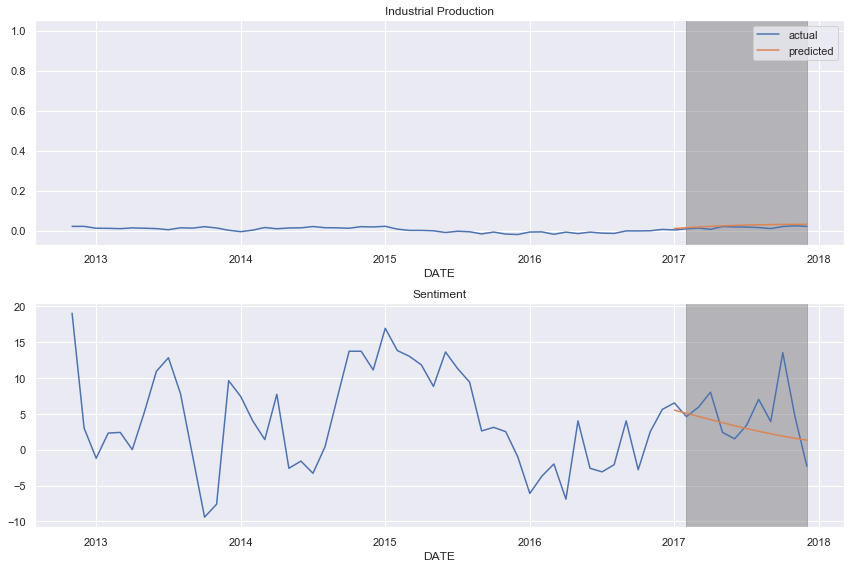

In [77]:
start = 430
preds = model.predict(start=480, end=len(df_transformed)-1)
preds.index = df_transformed.index[480:]

fig, axes = plt.subplots(nrows=2, figsize=(12, 8))

df_transformed.ip.iloc[start:].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[481:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.iloc[start:].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[481:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
fig.tight_layout();

### Out-of-sample forecasts

In [ ]:
forecast = mode.forecast(steps=12)

fig, axes = plt.subplots(nrows=2, figsize=(12, 8))

df_transformed.ip.plot(ax=axes[0], label='actual', title='Liquor')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed.sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1]
fig.tight_layout();